# imports and data load

In [115]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

In [2]:
words = open("names.txt", 'r').read().splitlines()
# words = open("names_ind.txt", 'r').read().splitlines()

# words des
print("length : ",len(words))
print("max word length : ",max(len(w) for w in words))
print("min word length : ",min(len(w) for w in words))
print(words[:5])

length :  32033
max word length :  15
min word length :  2
['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# 26 + 1 (alphabets + one special character)
N = torch.zeros((27, 27), dtype = torch.int32) #we store counts, we don't need float32

stoi = {chr(i+96):i for i in range(1,27)}
stoi['.'] = 0
# it is inverse of stoi for visulization purpose
itos = {i:s for s,i in stoi.items()}


for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

# bigram character level bigram model

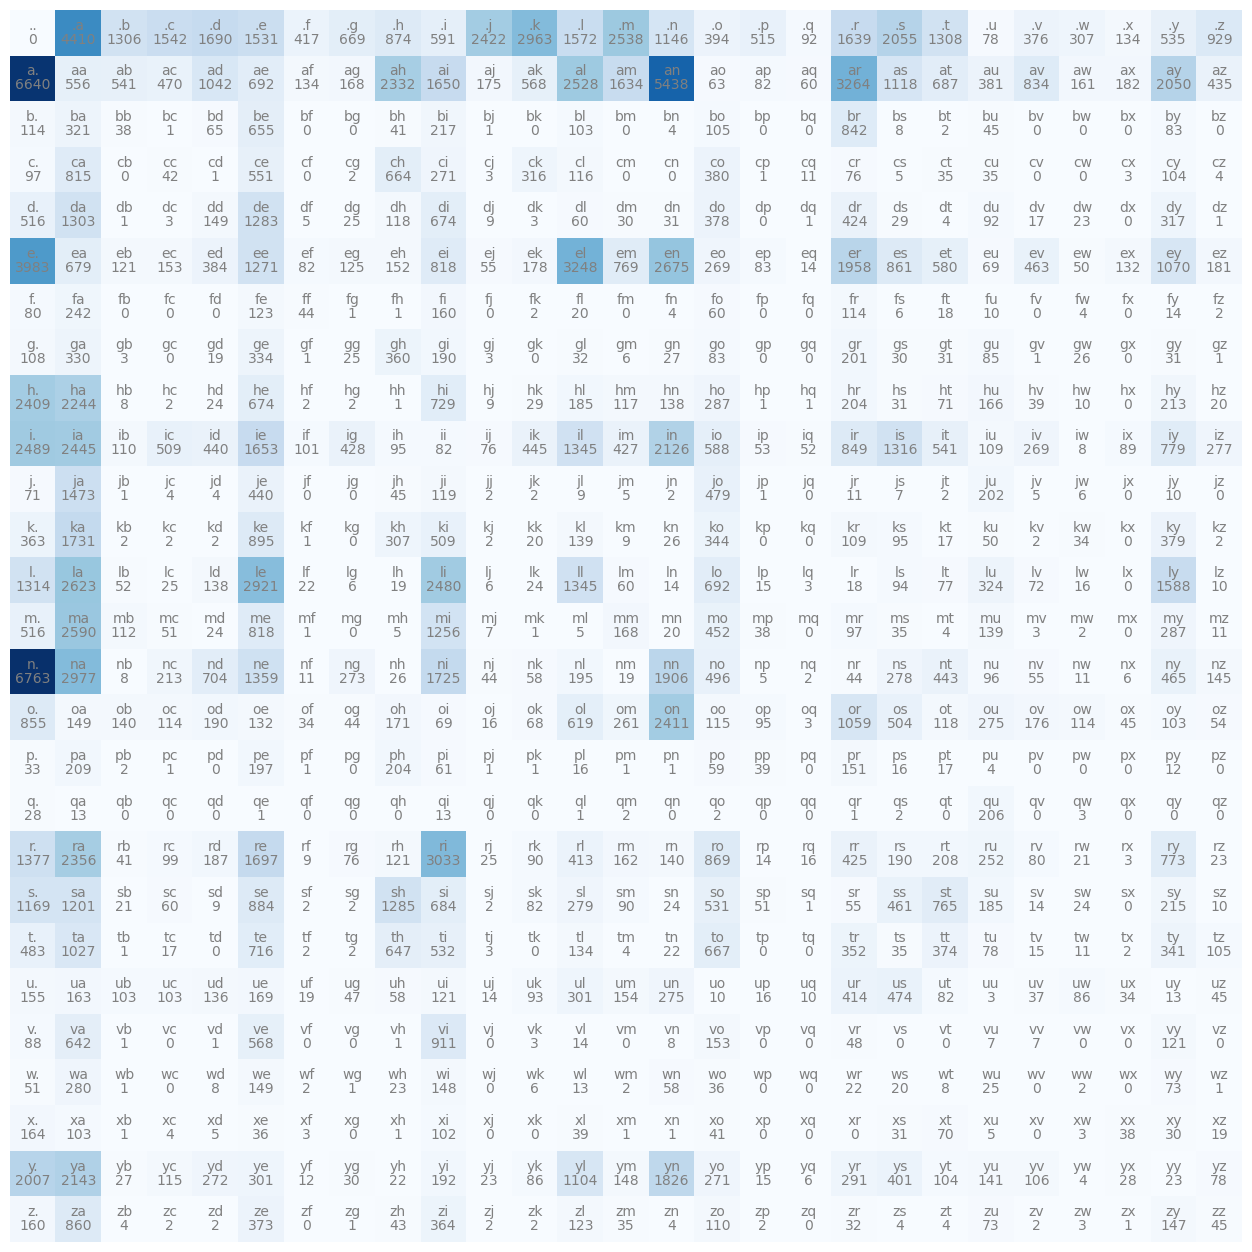

In [17]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j,i, chstr, ha="center", va= "bottom", color="gray")
        plt.text(j,i, N[i,j].item(), ha="center", va= "top", color="gray")
plt.axis('off');      

In [18]:
g = torch.Generator().manual_seed(2147483647)
out = []
ix = 0

# converting each value of tensor to probablistic value by its row
# N+1 add 1 to each value because 0 can make log function go -infinity
P = (N+1).float() #convert each int to float
# row_sums this sqeeze and sum all the rows an make a 27 X 1 column vecotor
row_sums = P.sum(1, keepdim=True) 
# when we divide with P(27X27) then pytorch expand(copy) row_sums from 27 X 1 to 27 X 27
# and did element wise division 
P /= row_sums #this is called brodcasting semantics in pytorch
P[0].sum() #every row sum equals 1

tensor(1.)

In [19]:
for i in range(10):
    name =''
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator = g).item()
        name += itos[ix]
        if ix == 0:  #if its find '.'
            break

    out.append(name)
print(out)

['junide.', 'janasah.', 'p.', 'cony.', 'a.', 'nn.', 'kohin.', 'tolian.', 'juee.', 'ksahnaauranilevias.']


In [8]:
# GOAL: maximize likelihood of the data w.r.t mode parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood  (lower the better)
# equivalent to minimizing the avg negative log likelihood (lower the better)(loss function)

# likelyhood is product of all probablities
# so we find log of probablities because log(a*b*c) = log(a) + log(b) + log(c)

In [20]:
log_likelihood = 0.0
counter = 0
for w in words: #['nishant']
    chs = ['.']+ list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        counter +=1
        # print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")

negative_log_likelihood = -log_likelihood
avg_negative_log_likelihood = negative_log_likelihood / counter

print(f'{log_likelihood=}')
print(f'{negative_log_likelihood=}')
print(f'{avg_negative_log_likelihood=}')

log_likelihood=tensor(-559951.5625)
negative_log_likelihood=tensor(559951.5625)
avg_negative_log_likelihood=tensor(2.4544)


# The Neural Network approch bigram

In [6]:
# SUMMARY

# first we have dataset of inputs(xs) and corret labels(ys).
# then generate 27 neuron weights(or 27 inputs) and no of neuron is also 27

# forward-pass 
# (We have to use diffrential function because we have to backpro it)
# first we have to encode xs into one-hot representation
# then we have to multiply it with the first layer of neurons to get logits
# then we do softmax
    ##### this is called Softmax ####
    # exp() the logits to remove -ve and get fake counts(counts never be -ve)
    # normalize the counts to get the probablistic score

In [7]:
# create the traning set of bigrams (X, Y)
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('no of examples: ', num)

# initialize the networks
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

no of examples:  228146


In [8]:
# gradient descent
xenc = F.one_hot(xs, num_classes=27).float() #cast to float becaue we feed float in NN
for k in range(50):
    # forward pass
    logits = xenc @ W #log-counts
    counts = logits.exp() #eqivalent to N from above
    prob = counts / counts.sum(1, keepdim=True)
    loss = -prob[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    print(loss.item())

    # backward pass
    W.grad = None #set grad to zero gradient
    loss.backward()

    # update
    W.data += -50 * W.grad

3.7686190605163574
3.3788068294525146
3.161090850830078
3.027186155319214
2.9344842433929443
2.8672313690185547
2.816654682159424
2.777146577835083
2.745253801345825
2.7188303470611572
2.696505546569824
2.6773719787597656
2.6608052253723145
2.6463515758514404
2.633665084838867
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.582256317138672
2.5764293670654297
2.5711238384246826
2.566272735595703
2.5618226528167725
2.5577263832092285
2.5539441108703613
2.550442695617676
2.5471925735473633
2.5441696643829346
2.5413525104522705
2.538722038269043
2.536262035369873
2.5339581966400146
2.531797409057617
2.5297679901123047
2.527860164642334
2.5260636806488037
2.5243709087371826
2.522773265838623
2.521263837814331
2.519836664199829
2.5184857845306396
2.5172057151794434
2.515990734100342
2.5148372650146484
2.5137410163879395
2.512697696685791
2.511704444885254
2.5107581615448


In [9]:
prob.shape

torch.Size([228146, 27])

In [11]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:

    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
pxzfay.
a.
nn.


# MLP

In [5]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F

# read all the words
words = open("names.txt", 'r').read().splitlines()
print('total words :: ', len(words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

def build_dataset(words,block_size):
    # making X and Y
    X, Y = [], []
    block_size = 5
    for w in words:
        
        w = block_size*'.' + w + '.'
        length = len(w)
        
        for i in range(length - 1): 
            try: 
                a = [stoi[j] for j in w[i:i+block_size]]
                b = stoi[w[i+block_size]]
                # print(w[i:i+block_size], ' ------> ', w[i+block_size])
                
                X.append(a)
                Y.append(b)
            except:
                continue
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

# parameters
EMB_SIZE = 12
BLOCK_SIZE = 5
BATCH_SIZE = 80

# building train, dev/validation, test dataset
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1],BLOCK_SIZE)
Xdev, Ydev = build_dataset(words[n1:n2],BLOCK_SIZE)
Xte, Yte = build_dataset(words[n2:],BLOCK_SIZE)

total words ::  32033
torch.Size([182625, 5]) torch.Size([182625])
torch.Size([22655, 5]) torch.Size([22655])
torch.Size([22866, 5]) torch.Size([22866])


In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,EMB_SIZE), generator = g)
W1 = torch.randn(((EMB_SIZE*BLOCK_SIZE) ,300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C,W1,b1,W2,b2]
for p in parameters:
    p.requires_grad = True

In [7]:
# total no of parameters
sum(p.nelement() for p in parameters)

26751

In [8]:
# 0.001 to 1
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

from tqdm import tqdm
# first(100 neuron) and second(27 neuron) layer
lri = []
lossi = []
stepi = []


In [15]:
for i in tqdm(range(50000)):
    # mini batch construct
    ix = torch.randint(0,Xtr.shape[0],(BATCH_SIZE,))  #random 32 index for X
    # forwarad pass
    emb = C[Xtr[ix]]  #[batchsize, blocksize, emmbeding size] lookup table for embeding
    h = torch.tanh(emb.view(-1,(EMB_SIZE*BLOCK_SIZE)) @ W1 + b1)  # converting [32, 3, 2] ==> [32,6] using view(), -1 will automatically decide another number which is 32 here
    logits = h @ W2 + b2  #[32,27]
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    if i<40000:
        lr = 0.1
    elif 40000<i<45000:
        lr = 0.05
    else:
        lr = 0.01
      #at last you do 0.01 for few iteration which is called learning rate decay which lower loss further
    for p in parameters:
        p.data += -lr * p.grad
    # stats
    # lri.append(lr)
    # stepi.append(i)
    # lossi.append(loss.log10().item())
print(loss.item())

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:01<00:00, 812.05it/s]

2.5389137268066406


In [16]:
# checking the loss in train dataset
emb = C[Xtr]
h = torch.tanh(emb.view(-1,(EMB_SIZE*BLOCK_SIZE)) @ W1 + b1)
logits = h @ W2 + b2  #[32,27]
loss = F.cross_entropy(logits, Ytr)
loss.item()

2.292124032974243

In [17]:
# checking the loss in dev dataset
emb = C[Xdev]
h = torch.tanh(emb.view(-1,(EMB_SIZE*BLOCK_SIZE)) @ W1 + b1)
logits = h @ W2 + b2  #[32,27]
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.3478024005889893

In [ ]:
plt.plot(stepi,lossi)

In [44]:
# checking the loss in test
emb = C[Xte]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2  #[32,27]
loss = F.cross_entropy(logits, Yte)
loss.item()

2.1777045726776123

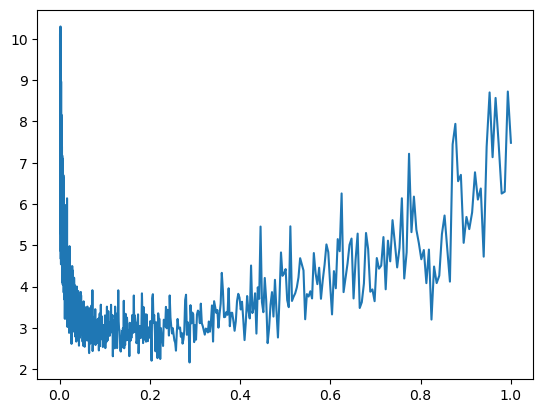

In [145]:
plt.plot(lri, lossi)

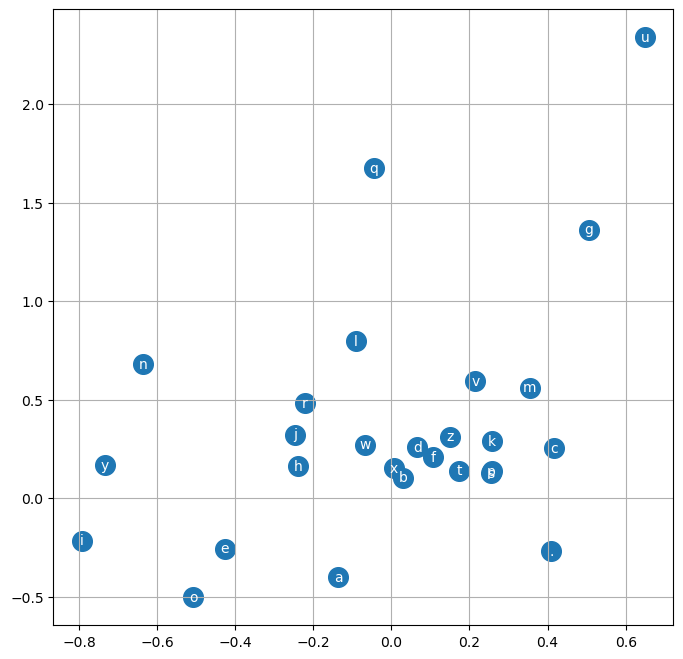

In [21]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

# MLP ( my own 3 layer)

In [1]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from tqdm import tqdm

# read all the words
words = open("names.txt", 'r').read().splitlines()
print('total words :: ', len(words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

def build_dataset(words,block_size):
    # making X and Y
    X, Y = [], []
    # block_size = 5
    for w in words:
        
        w = block_size*'.' + w + '.'
        length = len(w)
        
        for i in range(length - 1): 
            try: 
                a = [stoi[j] for j in w[i:i+block_size]]
                b = stoi[w[i+block_size]]
                # print(w[i:i+block_size], ' ------> ', w[i+block_size])
                
                X.append(a)
                Y.append(b)
            except:
                continue
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

total words ::  32033


In [2]:
# parameters
EMB_SIZE = 20
BLOCK_SIZE = 4
BATCH_SIZE = 128

# building train, dev/validation, test dataset
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1],BLOCK_SIZE)
Xdev, Ydev = build_dataset(words[n1:n2],BLOCK_SIZE)
Xte, Yte = build_dataset(words[n2:],BLOCK_SIZE)

torch.Size([182625, 4]) torch.Size([182625])
torch.Size([22655, 4]) torch.Size([22655])
torch.Size([22866, 4]) torch.Size([22866])


In [3]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,EMB_SIZE), generator = g)
W1 = torch.randn(((EMB_SIZE*BLOCK_SIZE) ,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,100), generator = g)
b2 = torch.randn(100, generator = g)
W3 = torch.randn((100,27), generator = g)
b3 = torch.randn(27, generator = g)
parameters = [C,W1,b1,W2,b2,W3,b3]
for p in parameters:
    p.requires_grad = True

# total no of parameters
print("Total no of parameters",sum(p.nelement() for p in parameters))

Total no of parameters 39567


In [4]:
for i in tqdm(range(100000)):
    
    # mini batch construct
    ix = torch.randint(0,Xtr.shape[0],(BATCH_SIZE,)) 
    
    # forwarad pass
    emb = C[Xtr[ix]]  #[batchsize, blocksize, emmbeding size]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1,(EMB_SIZE*BLOCK_SIZE)) @ W1 + b1)  # converting [32, 3, 2] ==> [32,6] using view(), -1 will automatically decide another number which is 32 here
    # print(h.shape)
    logits = h @ W2 + b2 
    # print(logits.shape)
    logits = logits @ W3 + b3
    # print(logits.shape)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    if i<80000:
        lr = 0.1
    elif 80000<i<95000:
        lr = 0.05
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

# checking the loss in train dataset
emb = C[Xtr]
h = torch.tanh(emb.view(-1,(EMB_SIZE*BLOCK_SIZE)) @ W1 + b1)
logits = h @ W2 + b2  #[32,27]
logits = logits @ W3 + b3
loss = F.cross_entropy(logits, Ytr)
print("train loss :: ",loss.item())

# checking the loss in dev dataset
emb = C[Xdev]
h = torch.tanh(emb.view(-1,(EMB_SIZE*BLOCK_SIZE)) @ W1 + b1)
logits = h @ W2 + b2  #[32,27]
logits = logits @ W3 + b3 
loss = F.cross_entropy(logits, Ydev)
print("Dev loss :: ",loss.item())

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [02:07<00:00, 787.00it/s]


train loss ::  2.1262762546539307
Dev loss ::  2.169604778289795


# makemore part 3

In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from tqdm import tqdm

# read all the words
words = open("names.txt", 'r').read().splitlines()
print('total words :: ', len(words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

def build_dataset(words,block_size):
    # making X and Y
    X, Y = [], []
    # block_size = 5
    for w in words:
        
        w = block_size*'.' + w + '.'
        length = len(w)
        
        for i in range(length - 1): 
            try: 
                a = [stoi[j] for j in w[i:i+block_size]]
                b = stoi[w[i+block_size]]
                # print(w[i:i+block_size], ' ------> ', w[i+block_size])
                
                X.append(a)
                Y.append(b)
            except:
                continue
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

# parameters
EMB_SIZE = 10
BLOCK_SIZE = 3
BATCH_SIZE = 32
max_steps = 200000
n_hidden = 200
# building train, dev/validation, test dataset
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1],BLOCK_SIZE)
Xdev, Ydev = build_dataset(words[n1:n2],BLOCK_SIZE)
Xte, Yte = build_dataset(words[n2:],BLOCK_SIZE)

total words ::  32033
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## general

In [3]:

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,EMB_SIZE),                         generator = g)
W1 = torch.randn(((EMB_SIZE*BLOCK_SIZE) ,n_hidden),    generator = g) * (5/3)/((EMB_SIZE*BLOCK_SIZE)**0.5)  #kaiming init
# b1 = torch.randn(n_hidden,                             generator = g) * 0.01
W2 = torch.randn((n_hidden,27),                        generator = g) * 0.01
b2 = torch.randn(27,                                   generator = g) * 0

# batchnorm parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2,bngain,bnbias]



for p in parameters:
    p.requires_grad = True
# total no of parameters
sum(p.nelement() for p in parameters)

12097

In [3]:
lossi = []
for i in range(max_steps):#tqdm(range(max_steps)):
    ix = torch.randint(0,Xtr.shape[0],(BATCH_SIZE,))  #random 32 index for X
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forwarad pass
    emb = C[Xb]  #[batchsize, blocksize, emmbeding size] lookup table for embeding
    embcat = emb.view(emb.shape[0],-1)
    # Linear layer
    hprect = embcat @ W1 #+ b1 we don't need b1 because it subtracted in hprect - bnmeani
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmeani = hprect.mean(0,keepdim=True)
    bnstdi = hprect.std(0,keepdim=True)
    hprect = bngain * ((hprect - bnmeani) / bnstdi) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running =  0.9990 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hprect)  # converting [32, 3, 2] ==> [32,6] using view(), -1 will automatically decide another number which is 32 here
    logits = h @ W2 + b2  #[32,27]
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # break

      0/ 200000: 3.3055
  10000/ 200000: 2.3777
  20000/ 200000: 2.2125
  30000/ 200000: 2.4853
  40000/ 200000: 1.8568
  50000/ 200000: 2.0228
  60000/ 200000: 2.2061
  70000/ 200000: 2.3042
  80000/ 200000: 2.4059
  90000/ 200000: 2.2107
 100000/ 200000: 2.1331
 110000/ 200000: 1.9700
 120000/ 200000: 2.2749
 130000/ 200000: 1.9726
 140000/ 200000: 1.8949
 150000/ 200000: 2.0804
 160000/ 200000: 1.9099
 170000/ 200000: 2.0366
 180000/ 200000: 1.8824
 190000/ 200000: 2.4178


In [6]:
# checking the loss in train dataset
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0],-1)
  hprect = embcat @ W1 + b1
  hprect = bngain * ((hprect - bnmean_running) / bnstd_running) + bnbias
  h = torch.tanh(hprect) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0666933059692383
val 2.1067512035369873


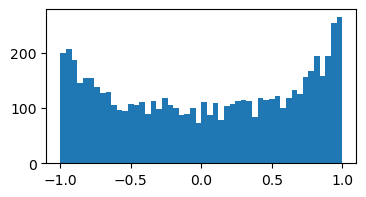

In [67]:
plt.figure(figsize=(4,2))
plt.hist(h.view(-1).tolist(),50);

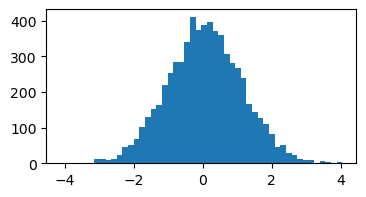

In [68]:
plt.figure(figsize=(4,2))
plt.hist(hprect.view(-1).tolist(),50);

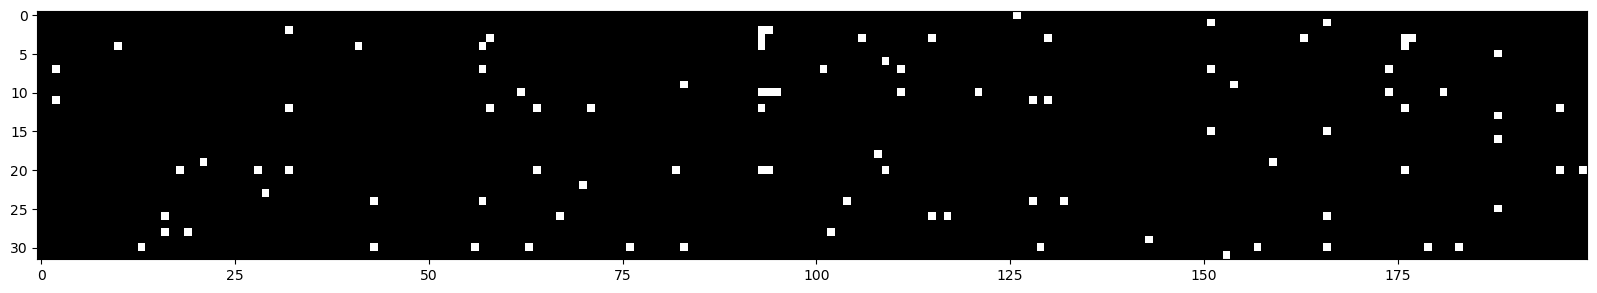

In [70]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='grey', interpolation='nearest');

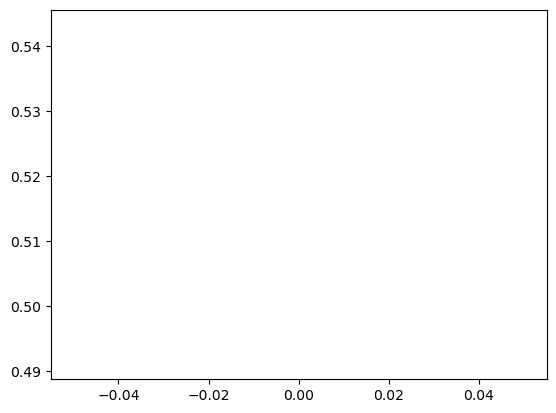

In [40]:
plt.plot(lossi);

## PYTORCHIFYING the above code

In [3]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from tqdm import tqdm

vocab_size = 27
block_size = 3

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [4]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in tqdm(range(max_steps)):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  # for layer in layers:
  #   layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.01 if i < 150000 else 0.001 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 20000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

  0%|                                                                              | 18/200000 [00:00<37:29, 88.88it/s]

      0/ 200000: 3.2870


  5%|███▋                                                                      | 10014/200000 [01:29<28:15, 112.08it/s]

  10000/ 200000: 2.4504


 10%|███████▍                                                                  | 20000/200000 [02:58<26:46, 112.01it/s]

  20000/ 200000: 2.1559


layer 2 (      Tanh): mean +0.01, std 0.62, saturated: 3.81%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 3.00%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 3.28%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.31%
layer 14 (      Tanh): mean -0.00, std 0.66, saturated: 2.34%


Text(0.5, 1.0, 'activation distribution')

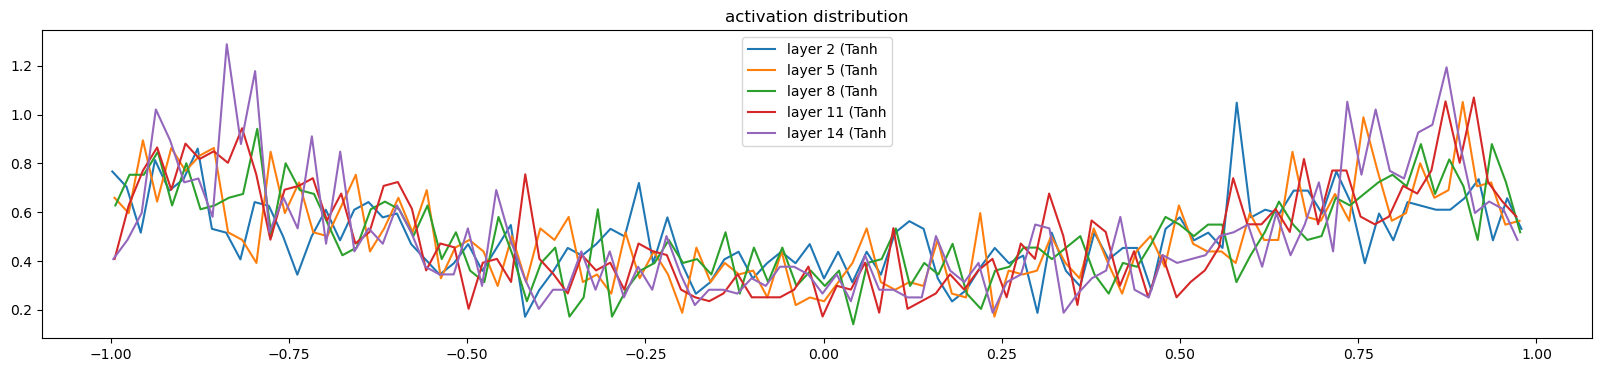

In [5]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [6]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

C:\Users\nisha\AppData\Local\Temp\ipykernel_5072\1958459093.py:6: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:494.)
  t = layer.out.grad


AttributeError: 'NoneType' object has no attribute 'mean'

<Figure size 2000x400 with 0 Axes>

weight   (27, 10) | mean +0.000000 | std 1.128809e-02 | grad:data ratio 1.127836e-02
weight  (30, 100) | mean +0.000106 | std 1.430697e-02 | grad:data ratio 7.579557e-02
weight (100, 100) | mean -0.000123 | std 1.231649e-02 | grad:data ratio 1.206448e-01
weight (100, 100) | mean -0.000131 | std 1.183609e-02 | grad:data ratio 1.152861e-01
weight (100, 100) | mean -0.000099 | std 1.158250e-02 | grad:data ratio 1.135065e-01
weight (100, 100) | mean -0.000036 | std 1.122389e-02 | grad:data ratio 1.101761e-01
weight  (100, 27) | mean -0.000081 | std 1.996804e-02 | grad:data ratio 1.924029e-01


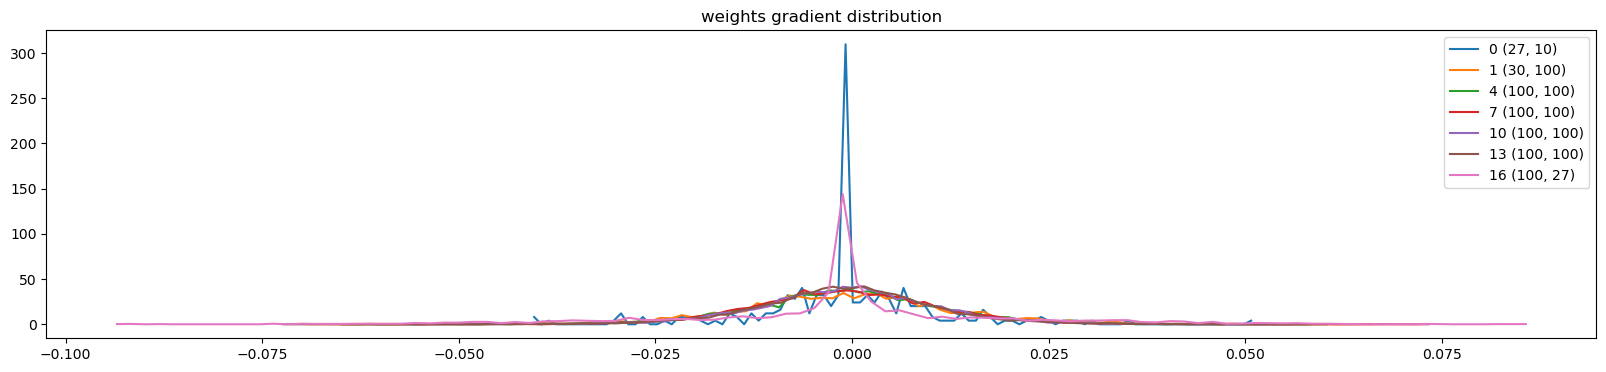

In [7]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

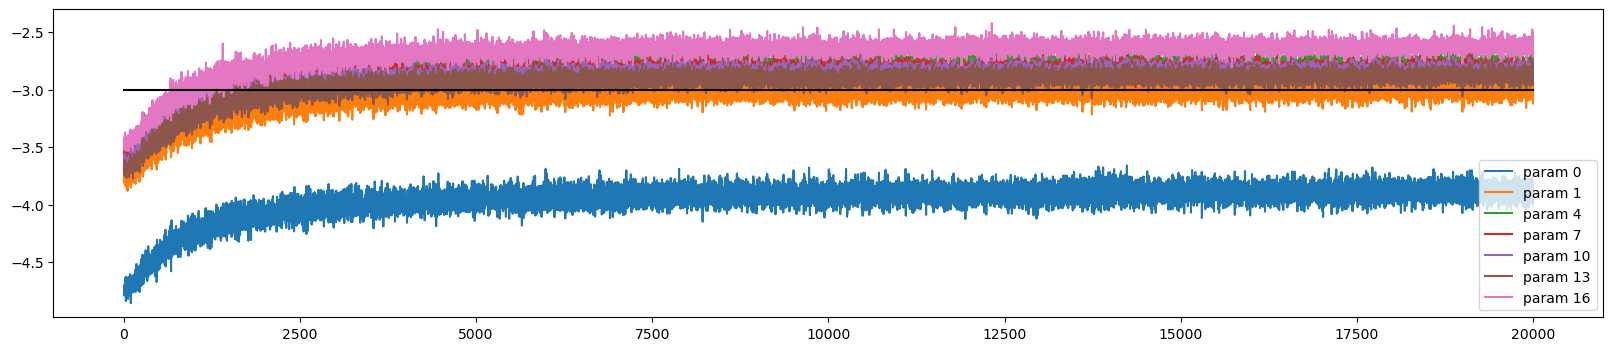

In [8]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

# Makemore part 4 : backprop ninja

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3262, grad_fn=<NegBackward0>)

In [18]:
h.shape,W2.shape,dlogits.shape

(torch.Size([32, 64]), torch.Size([64, 27]), torch.Size([32, 27]))

In [ ]:
dlogits @ W2.view(

In [22]:
W2.transpose(0,1).shape

torch.Size([27, 64])

In [ ]:
64, 27 32, 27  = > 32 64
32 * 27

In [15]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one
# -----------------
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = torch.zeros_like(probs)
dprobs = 1.0/probs * dlogprobs

dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv

dcounts += torch.ones_like(counts) * dcounts_sum

dnorm_logits = norm_logits.exp() * dcounts

dlogits = dnorm_logits.clone()

dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

dlogits += (logits == logit_maxes).float() * dlogit_maxes

dh = W2 
# -----------------

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)

# cmp('h', dh, h)
# cmp('W2', dW2, W2)
# cmp('b2', db2, b2)
# cmp('hpreact', dhpreact, hpreact)
# cmp('bngain', dbngain, bngain)
# cmp('bnbias', dbnbias, bnbias)
# cmp('bnraw', dbnraw, bnraw)
# cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
# cmp('bnvar', dbnvar, bnvar)
# cmp('bndiff2', dbndiff2, bndiff2)
# cmp('bndiff', dbndiff, bndiff)
# cmp('bnmeani', dbnmeani, bnmeani)
# cmp('hprebn', dhprebn, hprebn)
# cmp('embcat', dembcat, embcat)
# cmp('W1', dW1, W1)
# cmp('b1', db1, b1)
# cmp('emb', demb, emb)
# cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
